In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from wandb.integration.keras import WandbCallback


import wandb
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Abordar el Desbalance

**Código para Contar Imágenes por Clase y Conjunto**

In [11]:
import os

def count_images_in_splits(data_splits_dir):
    splits = ['train', 'val', 'test']
    split_counts = {}
    
    for split in splits:
        split_dir = os.path.join(data_splits_dir, split)
        class_counts = {}
        total_count = 0
        
        if os.path.exists(split_dir):
            classes = sorted(os.listdir(split_dir))
            for cls in classes:
                cls_dir = os.path.join(split_dir, cls)
                if os.path.isdir(cls_dir):
                    count = len(os.listdir(cls_dir))
                    class_counts[cls] = count
                    total_count += count
            split_counts[split] = {'total': total_count, 'classes': class_counts}
        else:
            print(f"El directorio {split_dir} no existe.")
    return split_counts

# Directorio principal donde se encuentran los splits
data_split_dir = 'data_split'

# Obtener los conteos
split_counts = count_images_in_splits(data_split_dir)

**Código para Mostrar Conteos**

In [12]:
def print_split_counts(split_counts):
    for split, data in split_counts.items():
        print(f"\nConjunto: {split}")
        print(f"Total de imágenes: {data['total']}")
        print("Imágenes por clase:")
        for cls, count in data['classes'].items():
            print(f"  Clase {cls}: {count} imágenes")

print_split_counts(split_counts)


Conjunto: train
Total de imágenes: 7378
Imágenes por clase:
  Clase ASC-H: 592 imágenes
  Clase ASC-US: 387 imágenes
  Clase HSIL: 1089 imágenes
  Clase LSIL: 870 imágenes
  Clase Negative: 4338 imágenes
  Clase SCC: 102 imágenes

Conjunto: val
Total de imágenes: 1847
Imágenes por clase:
  Clase ASC-H: 148 imágenes
  Clase ASC-US: 97 imágenes
  Clase HSIL: 273 imágenes
  Clase LSIL: 218 imágenes
  Clase Negative: 1085 imágenes
  Clase SCC: 26 imágenes

Conjunto: test
Total de imágenes: 2309
Imágenes por clase:
  Clase ASC-H: 185 imágenes
  Clase ASC-US: 122 imágenes
  Clase HSIL: 341 imágenes
  Clase LSIL: 272 imágenes
  Clase Negative: 1356 imágenes
  Clase SCC: 33 imágenes


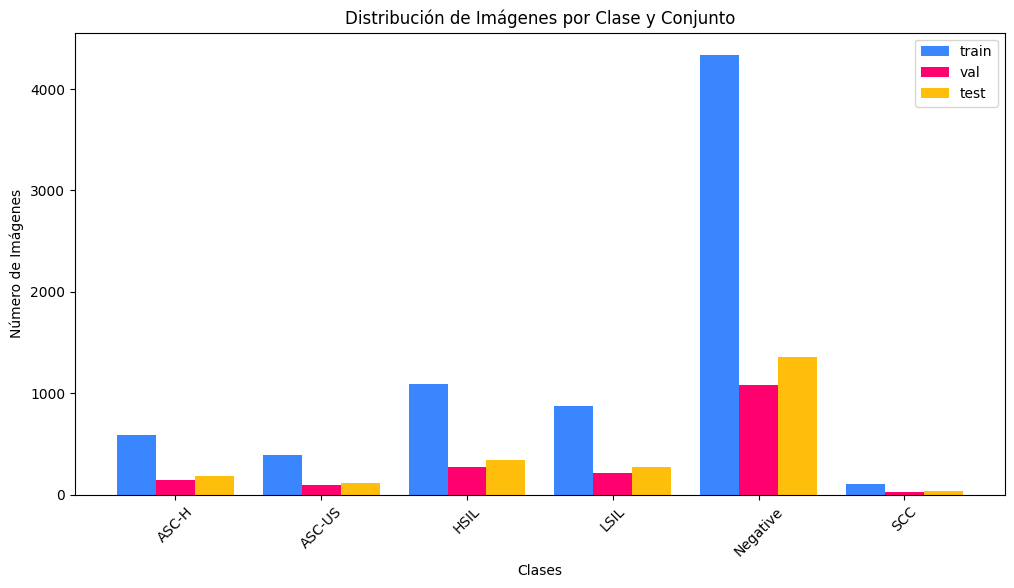

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def plot_class_distribution_per_split(split_counts):
    # Aseguramos que todas las clases estén presentes en todos los splits
    classes = sorted(set().union(*(split['classes'].keys() for split in split_counts.values())))
    splits = list(split_counts.keys())
    class_counts_per_split = {cls: [] for cls in classes}
    
    # Recolectamos los conteos para cada clase en cada split
    for split in splits:
        for cls in classes:
            count = split_counts[split]['classes'].get(cls, 0)  # Si una clase no está presente, se coloca un 0
            class_counts_per_split[cls].append(count)
    
    x = np.arange(len(classes))
    total_width = 0.8
    width = total_width / len(splits)
    
    colors = ['#3A86FF', '#FF006E', '#FFBE0B']  # Colores para los diferentes conjuntos (train, val, test)
    
    plt.figure(figsize=(12, 6))
    
    for i, split in enumerate(splits):
        counts = [class_counts_per_split[cls][i] for cls in classes]
        plt.bar(x + i * width, counts, width=width, label=split, color=colors[i])  # Cambiar color por cada conjunto
    
    plt.xlabel('Clases')
    plt.ylabel('Número de Imágenes')
    plt.title('Distribución de Imágenes por Clase y Conjunto')
    plt.xticks(x + width, classes, rotation=45)
    plt.legend()
    plt.show()

# Ejemplo de estructura 'split_counts'
split_counts = {
    'train': {
        'classes': {
            'ASC-H': 592,
            'ASC-US': 387,
            'HSIL': 1089,
            'LSIL': 870,
            'Negative': 4338,
            'SCC': 102
        }
    },
    'val': {
        'classes': {
            'ASC-H': 148,
            'ASC-US': 97,
            'HSIL': 273,
            'LSIL': 218,
            'Negative': 1085,
            'SCC': 26
        }
    },
    'test': {
        'classes': {
            'ASC-H': 185,
            'ASC-US': 114,
            'HSIL': 341,
            'LSIL': 272,
            'Negative': 1356,
            'SCC': 33
        }
    }
}

# Llamada a la función para graficar
plot_class_distribution_per_split(split_counts)

**Data Aumentation**

In [14]:
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# Función para mejorar nitidez
def enhance_sharpness(image):
    kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
    sharp_image = cv2.filter2D(image, -1, kernel)
    return sharp_image

# Función para aplicar CLAHE
def apply_clahe(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return final

def augment_class_images(class_name, current_count, target_count, class_dir):
    datagen = ImageDataGenerator(
        rotation_range=10,  # Rotación limitada para no distorsionar la imagen
        width_shift_range=0.05,  # Shift más limitado
        height_shift_range=0.05,  # Shift más limitado
        shear_range=0.1,  # Cizallamiento menor
        horizontal_flip=True,
        fill_mode='nearest'
    )

    images = os.listdir(class_dir)
    num_existing_images = len(images)
    images_needed = target_count - current_count
    i = 0

    print(f"Generando {images_needed} imágenes para la clase {class_name}")

    while i < images_needed:
        img_name = images[i % num_existing_images]
        img_path = os.path.join(class_dir, img_name)
        img = load_img(img_path)
        x = img_to_array(img)

        # Aplicar solo mejoras de nitidez y CLAHE para mejorar la imagen sin perder calidad
        img_array = np.array(x, dtype=np.uint8)
        sharp_img = enhance_sharpness(img_array)
        final_img = apply_clahe(sharp_img)

        # Preparar la imagen para la augmentación
        x_aug = final_img.reshape((1,) + final_img.shape)

        save_prefix = 'aug_' + img_name.split('.')[0]
        aug_iter = datagen.flow(
            x_aug,
            batch_size=1,
            save_to_dir=class_dir,
            save_prefix=save_prefix,
            save_format='png'
        )
        next(aug_iter)
        i += 1

# Directorio del conjunto de entrenamiento
train_dir = 'data_split/train'

# Definir la cantidad objetivo de imágenes por clase
target_count = 2000

# Datos de las clases
class_counts = {
    'ASC-H': 592,
    'ASC-US': 387,
    'HSIL': 1089,
    'LSIL': 870,
    'Negative': 4338,  # No necesitamos aumentar esta clase
    'SCC': 102
}

# Aplicar aumento de datos a cada clase minoritaria
for class_name, count in class_counts.items():
    if count < target_count and class_name != 'Negative':
        class_dir = os.path.join(train_dir, class_name)
        augment_class_images(class_name, count, target_count, class_dir)

Generando 1408 imágenes para la clase ASC-H
Generando 1613 imágenes para la clase ASC-US
Generando 911 imágenes para la clase HSIL
Generando 1130 imágenes para la clase LSIL
Generando 1898 imágenes para la clase SCC


**Comparación antes y después del Balanceo**

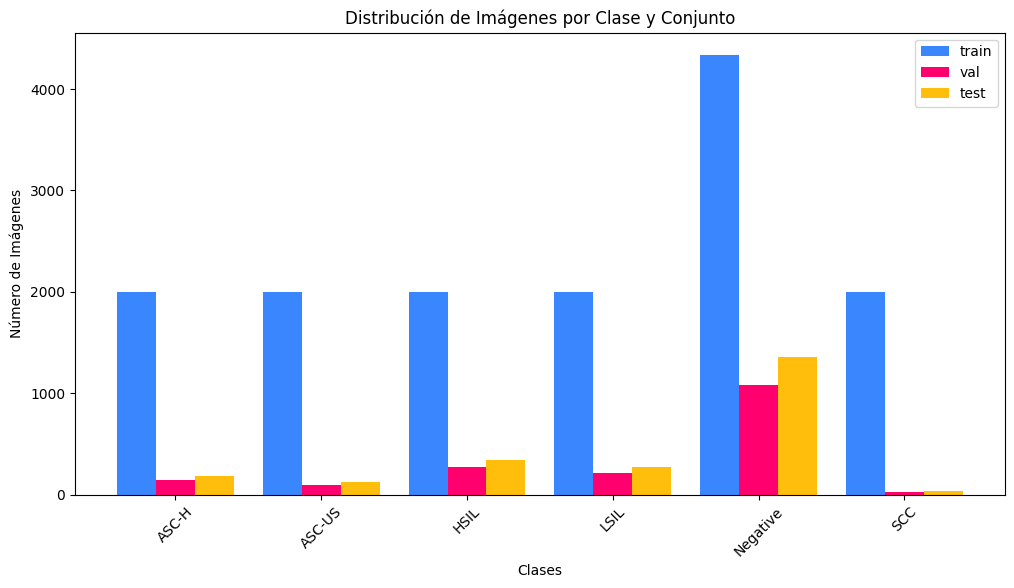

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Función para contar las imágenes en cada clase por conjunto
def count_images_in_split(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            class_counts[class_name] = len([f for f in os.listdir(class_dir) if f.endswith('.png') or f.endswith('.jpg')])
    return class_counts

# Directorios de los conjuntos (cambia los directorios según tu estructura de carpetas)
train_dir = 'data_split/train'
val_dir = 'data_split/val'
test_dir = 'data_split/test'

# Contamos las imágenes en cada clase para cada conjunto
split_counts = {
    'train': {'classes': count_images_in_split(train_dir)},
    'val': {'classes': count_images_in_split(val_dir)},
    'test': {'classes': count_images_in_split(test_dir)}
}

# Función para graficar la distribución de imágenes por clase en cada conjunto
def plot_class_distribution_per_split(split_counts):
    # Aseguramos que todas las clases estén presentes en todos los splits
    classes = sorted(set().union(*(split['classes'].keys() for split in split_counts.values())))
    splits = list(split_counts.keys())
    class_counts_per_split = {cls: [] for cls in classes}
    
    # Recolectamos los conteos para cada clase en cada split
    for split in splits:
        for cls in classes:
            count = split_counts[split]['classes'].get(cls, 0)  # Si una clase no está presente, se coloca un 0
            class_counts_per_split[cls].append(count)
    
    x = np.arange(len(classes))
    total_width = 0.8
    width = total_width / len(splits)
    
    colors = ['#3A86FF', '#FF006E', '#FFBE0B']  # Colores para los diferentes conjuntos (train, val, test)
    
    plt.figure(figsize=(12, 6))
    
    for i, split in enumerate(splits):
        counts = [class_counts_per_split[cls][i] for cls in classes]
        plt.bar(x + i * width, counts, width=width, label=split, color=colors[i])  # Cambiar color por cada conjunto
    
    plt.xlabel('Clases')
    plt.ylabel('Número de Imágenes')
    plt.title('Distribución de Imágenes por Clase y Conjunto')
    plt.xticks(x + width, classes, rotation=45)
    plt.legend()
    plt.show()

# Llamada a la función para graficar
plot_class_distribution_per_split(split_counts)

# W&B 

In [16]:
import wandb
wandb.login()

True

## Modelo ViT

**Importar y Definir el Modelo ViT**

In [32]:
import tensorflow as tf
from vit_keras import vit
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Definir el modelo base ViT
IMG_HEIGHT, IMG_WIDTH = 224, 224

# Cargar el modelo ViT preentrenado
base_model_vit = vit.vit_b16(
    image_size=IMG_HEIGHT,
    pretrained=True,
    include_top=False,
    pretrained_top=False
)

# Congelar las capas base
base_model_vit.trainable = False

# Crear el modelo completo
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model_vit(inputs)
x = tf.keras.layers.Dense(256, activation='relu')(x)
outputs = tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')(x)
model_vit = tf.keras.Model(inputs=inputs, outputs=outputs)

# Calcular los pesos de clase
classes = train_generator.classes
class_weights_values = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)
class_weights = {i: weight for i, weight in enumerate(class_weights_values)}
print("Pesos de clase:", class_weights)

/Users/achula/miniconda3/envs/td8/lib/python3.8/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Pesos de clase: {0: 1.1946666666666668, 1: 1.1946666666666668, 2: 1.1946666666666668, 3: 1.1946666666666668, 4: 0.5507914553557707, 5: 1.1958625291958624}


**Entrenar el Modelo ViT**

In [2]:
from wandb.integration.keras import WandbCallback

In [4]:
# Entrenar y evaluar el modelo ViT
model_vit, history_vit = train_and_evaluate('ViT', base_model_vit, train_generator, val_generator, class_weights)

NameError: name 'base_model_vit' is not defined

## Entrenar el Modelo Swin Transformer

**Importar y Definir el Modelo Swin Transformer**

In [ ]:
# Definir el modelo base Swin Transformer
base_model_swin = keras_cv.models.SwinTransformer(
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    pretrained=True,
    # Hiperparámetros del modelo
    patch_size=4,
    window_size=7,
    embed_dim=96,
    depths=[2, 2, 6, 2],
    num_heads=[3, 6, 12, 24],
    dropout_rate=0.1,
    classifier_activation=None
)

# Modelo ViT

## 1. Importación de Librerías

In [19]:
import os
import numpy as np
import tensorflow as tf
import keras_cv
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import wandb
from wandb.integration.keras import WandbCallback
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend


/Users/achula/miniconda3/envs/td8/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Preparación de los Datos

**Definir Directorios y Parámetros**

In [20]:
# Directorios de los conjuntos de datos
train_dir = 'data_split/train'
val_dir = 'data_split/val'
test_dir = 'data_split/test'

# Tamaño de las imágenes y batch size
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

**Crear Generadores de Datos**

In [21]:
# Generador para el conjunto de entrenamiento
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Generador para el conjunto de validación
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Generador para el conjunto de prueba
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Importante para evaluación
)

Found 14336 images belonging to 6 classes.
Found 1847 images belonging to 6 classes.
Found 2309 images belonging to 6 classes.


**Calcular Pesos de Clase**

In [22]:
# Obtener las etiquetas de clase
classes = train_generator.classes

# Calcular los pesos de clase
class_weights_values = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)

# Crear el diccionario de pesos de clase
class_weights = {i: weight for i, weight in enumerate(class_weights_values)}
print("Pesos de clase:", class_weights)

Pesos de clase: {0: 1.1946666666666668, 1: 1.1946666666666668, 2: 1.1946666666666668, 3: 1.1946666666666668, 4: 0.5507914553557707, 5: 1.1958625291958624}


## 3. Definición del Modelo ViT con Keras-CV

**Importar y Definir el Modelo ViT**

In [4]:
from keras_cv.models import VisionTransformerClassifier  # Importación correcta

# Definir el modelo ViT utilizando Keras-CV
model_vit = ViTClassifier.from_preset(
    "vit_base_resnet50",  # Puedes elegir el preset que prefieras
    num_classes=train_generator.num_classes,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

ImportError: cannot import name 'VisionTransformerClassifier' from 'keras_cv.models' (/Users/achula/miniconda3/envs/td8/lib/python3.8/site-packages/keras_cv/models/__init__.py)

# Modelo ResNet50

##  1. Importar Librerías Necesarias

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
from wandb.integration.keras import WandbCallback

## 2. Configurar Weights & Biases (W&B)

In [3]:
# Iniciar sesión en W&B
wandb.login()

# Inicializar un nuevo experimento
wandb.init(project='clasificacion-celulas', name='ResNet50_Model')

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: azulnogueraa (tp3-td6). Use `wandb login --relogin` to force relogin


## Preparación de los Datos

**Definir Directorios y Parámetros**

In [4]:
# Directorios de los conjuntos de datos
train_dir = 'data_split/train'
val_dir = 'data_split/val'
test_dir = 'data_split/test'

# Tamaño de las imágenes y batch size
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

**Crear Generadores de Datos**

In [5]:
# Generador para el conjunto de entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Generador para el conjunto de validación
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Generador para el conjunto de prueba
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 14336 images belonging to 6 classes.
Found 1847 images belonging to 6 classes.
Found 2309 images belonging to 6 classes.


**Calcular Pesos de Clase**

In [6]:
# Obtener las etiquetas de clase
classes = train_generator.classes

# Calcular los pesos de clase
class_weights_values = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)

# Crear el diccionario de pesos de clase
class_weights = {i: weight for i, weight in enumerate(class_weights_values)}
print("Pesos de clase:", class_weights)

Pesos de clase: {0: 1.1946666666666668, 1: 1.1946666666666668, 2: 1.1946666666666668, 3: 1.1946666666666668, 4: 0.5507914553557707, 5: 1.1958625291958624}


##  4. Definición del Modelo ResNet50

**Cargar el Modelo Base ResNet50**

In [7]:
# Cargar el modelo base ResNet50 preentrenado
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

94765736/94765736 [==============================] - 4s 0us/step


**Congelar las Capas del Modelo Base**

In [8]:
# Congelar las capas del modelo base
base_model.trainable = False

**Añadir Capas Personalizadas**

In [9]:
from tensorflow.keras import layers

# Crear el modelo completo
inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(train_generator.num_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)

## 5. Compilar y Entrenar el Modelo

**Compilar el Modelo**

In [10]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

**Definir Callbacks**

In [13]:
# Crear el directorio para guardar el mejor modelo
checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

model_checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'best_model_ResNet50'),
    save_best_only=True,
    save_format='tf'
)

# Definir los callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    model_checkpoint_callback,
    WandbCallback()
]

**Entrenar el Modelo**

In [14]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/20
448/448 [==============================] - ETA: 0s - loss: 1.5788 - accuracy: 0.4280INFO:tensorflow:Assets written to: checkpoints/best_model_ResNet50/assets


INFO:tensorflow:Assets written to: checkpoints/best_model_ResNet50/assets
/Users/achula/miniconda3/envs/td8/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/achula/achula/td8/Proyecto-PAP/wandb/run-20241005_173727-ojra4c0n/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/achula/achula/td8/Proyecto-PAP/wandb/run-20241005_173727-ojra4c0n/files/model-best/assets
wandb: Adding directory to artifact (/Users/achula/achula/td8/Proyecto-PAP/wandb/run-20241005_173727-ojra4c0n/files/model-best)... Done. 0.5s


448/448 [==============================] - 480s 1s/step - loss: 1.5788 - accuracy: 0.4280 - val_loss: 1.4484 - val_accuracy: 0.5712
Epoch 2/20
448/448 [==============================] - ETA: 0s - loss: 1.5630 - accuracy: 0.4353INFO:tensorflow:Assets written to: checkpoints/best_model_ResNet50/assets


INFO:tensorflow:Assets written to: checkpoints/best_model_ResNet50/assets
/Users/achula/miniconda3/envs/td8/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/achula/achula/td8/Proyecto-PAP/wandb/run-20241005_173727-ojra4c0n/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/achula/achula/td8/Proyecto-PAP/wandb/run-20241005_173727-ojra4c0n/files/model-best/assets
wandb: Adding directory to artifact (/Users/achula/achula/td8/Proyecto-PAP/wandb/run-20241005_173727-ojra4c0n/files/model-best)... Done. 0.3s


448/448 [==============================] - 509s 1s/step - loss: 1.5630 - accuracy: 0.4353 - val_loss: 1.4092 - val_accuracy: 0.5891
Epoch 3/20
448/448 [==============================] - 1490s 3s/step - loss: 1.5576 - accuracy: 0.4392 - val_loss: 1.4096 - val_accuracy: 0.5560
Epoch 4/20
448/448 [==============================] - 778s 2s/step - loss: 1.5467 - accuracy: 0.4463 - val_loss: 1.4243 - val_accuracy: 0.5604
Epoch 5/20
448/448 [==============================] - 828s 2s/step - loss: 1.5375 - accuracy: 0.4528 - val_loss: 1.4836 - val_accuracy: 0.5593
Epoch 6/20
448/448 [==============================] - 823s 2s/step - loss: 1.5359 - accuracy: 0.4534 - val_loss: 1.4356 - val_accuracy: 0.5874
Epoch 7/20
448/448 [==============================] - ETA: 0s - loss: 1.5385 - accuracy: 0.4559INFO:tensorflow:Assets written to: checkpoints/best_model_ResNet50/assets


INFO:tensorflow:Assets written to: checkpoints/best_model_ResNet50/assets
/Users/achula/miniconda3/envs/td8/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/achula/achula/td8/Proyecto-PAP/wandb/run-20241005_173727-ojra4c0n/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/achula/achula/td8/Proyecto-PAP/wandb/run-20241005_173727-ojra4c0n/files/model-best/assets
wandb: Adding directory to artifact (/Users/achula/achula/td8/Proyecto-PAP/wandb/run-20241005_173727-ojra4c0n/files/model-best)... Done. 0.5s


448/448 [==============================] - 862s 2s/step - loss: 1.5385 - accuracy: 0.4559 - val_loss: 1.3721 - val_accuracy: 0.5734
Epoch 8/20
448/448 [==============================] - 2475s 6s/step - loss: 1.5313 - accuracy: 0.4604 - val_loss: 1.4296 - val_accuracy: 0.5566
Epoch 9/20
448/448 [==============================] - 11442s 26s/step - loss: 1.5222 - accuracy: 0.4646 - val_loss: 1.4053 - val_accuracy: 0.5874
Epoch 10/20
448/448 [==============================] - ETA: 0s - loss: 1.5210 - accuracy: 0.4616INFO:tensorflow:Assets written to: checkpoints/best_model_ResNet50/assets


INFO:tensorflow:Assets written to: checkpoints/best_model_ResNet50/assets
/Users/achula/miniconda3/envs/td8/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/achula/achula/td8/Proyecto-PAP/wandb/run-20241005_173727-ojra4c0n/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/achula/achula/td8/Proyecto-PAP/wandb/run-20241005_173727-ojra4c0n/files/model-best/assets
wandb: Adding directory to artifact (/Users/achula/achula/td8/Proyecto-PAP/wandb/run-20241005_173727-ojra4c0n/files/model-best)... Done. 0.4s


448/448 [==============================] - 487s 1s/step - loss: 1.5210 - accuracy: 0.4616 - val_loss: 1.3581 - val_accuracy: 0.5864
Epoch 11/20
448/448 [==============================] - 28339s 63s/step - loss: 1.5127 - accuracy: 0.4727 - val_loss: 1.4090 - val_accuracy: 0.5604
Epoch 12/20
448/448 [==============================] - ETA: 0s - loss: 1.5022 - accuracy: 0.4728 

KeyboardInterrupt: 

## 6. Evaluación y Guardado de Resultados

**Evaluar el Modelo en el Conjunto de Prueba**

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")

**Registrar Resultados en W&B**

In [ ]:
wandb.log({'test_loss': test_loss, 'test_accuracy': test_acc})
wandb.finish()

**Guardar el Modelo Entrenado**

In [ ]:
model.save('modelos/ResNet50_modelo.keras')

## 7. Visualización de Resultados

**Visualizar Métricas de Entrenamiento**

In [ ]:
# Gráfica de precisión
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Gráfica de pérdida
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

**Matriz de Confusión**

In [ ]:
from sklearn.metrics import confusion_matrix

# Obtener predicciones
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión - ResNet50')
plt.show()

## 8. Fine-Tuning (Ajuste Fino) del Modelo (Opcional)

**Descongelar Capas Específicas**

In [ ]:
# Descongelar las últimas capas del modelo base
base_model.trainable = True

# Congelar las primeras N capas
fine_tune_at = 100  # Número de capas que deseas congelar
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

**Compilar el Modelo Nuevamente**

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Tasa de aprendizaje más baja para el ajuste fino
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

**Entrenar el Modelo Nuevamente**

In [ ]:
history_fine = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=callbacks
)

**Evaluar el Modelo Ajustado**

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Precisión en el conjunto de prueba después del ajuste fino: {test_acc:.4f}")